<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1E4ualtCve7qaOs8uWHGczK5OtPOGobhO?usp=sharing">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# **Import Data from Kaggle to Google Colab**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 39% 10.0M/25.7M [00:00<00:00, 26.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 58.0MB/s]


In [ ]:
!ls

imdb-dataset-of-50k-movie-reviews.zip  kaggle.json  sample_data


# **Importing Necessary Libraries**

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional,Flatten,Dropout
from keras.utils.np_utils import to_categorical
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Extract Files**

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('imdb-dataset-of-50k-movie-reviews.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

df = pd.read_csv('/content/files/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# **Visualizing Data**

Positive reviews are 25000 and negative reviews are 25000 of total 50000 


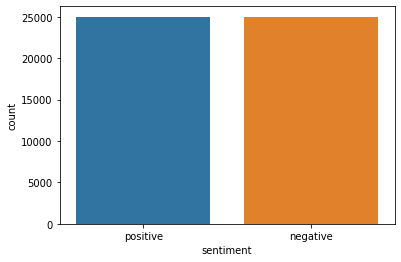

In [ ]:
negative = len(df[df['sentiment']=='positive'])
positive = len(df) - negative
sns.countplot(df['sentiment'])
print('Positive reviews are {} and negative reviews are {} of total {} '.format(positive,negative,len(df)))

Converting the labels positive and negative as 1,0 so that they can be fed to the neural network to predict whether the given review is a positive or negative. Splitting of data 80% for the training and remaining 20% for testing.

In [ ]:
le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(df['review'].values,df['sentiment'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

# **Pre-Processing The Text**


Functions to pre-process the review text using Natural Language Processing techniques as they contain unwanted elements.

In [ ]:
def remove_special_chars(tweets):
        alphanumeric=""
        for character in tweets:
            if character.isalpha() or character==" ":
                alphanumeric += character
        return alphanumeric
def remove_tags(text):
     return re.compile(r"<[^>]+>").sub(" ", text)
def remove_num(text):
     return "".join(re.sub(r"([0–9]+)"," ",text))
df.review=df.review.apply(lambda x : remove_tags(x))
df.review=df.review.apply(lambda x : remove_num(x))
df.review=(df.review).apply(remove_special_chars)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming te...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


Using tokenizer to produce token for a given word and taking maximum length of 200 character of a review and after we simply truncate the input review and then padded the input to max len of 200.

In [ ]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 500,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 500,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 112276


Using glove vectors for embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-09-08 11:36:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-08 11:36:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-08 11:36:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip
!ls

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
files		   glove.6B.300d.txt  imdb-dataset-of-50k-movie-reviews.zip
glove.6B.100d.txt  glove.6B.50d.txt   kaggle.json
glove.6B.200d.txt  glove.6B.zip       sample_data


In [ ]:
embedded_words = {}
with open ('/content/glove.6B.200d.txt') as file:
  for line in file:
    words, coeff = line.split(maxsplit=1)
    coeff = np.array(coeff.split(),dtype = float)
    embedded_words[words] = coeff

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1,200))
for word, i in word_index.items():
  embedding_vector = embedded_words.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

# **Design a sequential model using Keras. Add different layers such as embedding layer, Bi-LSTM layer and a dense layer.**

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,200,weights=[embedding_matrix],input_length=500,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 200)          22455400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               135680    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_pad_sequence,training_labels, epochs = 30, callbacks=[es], validation_data=(test_pad_sequence,testing_labels))

Epoch 1/30
1250/1250 [==============================] - 594s 475ms/step - loss: 0.4901 - accuracy: 0.7585 - val_loss: 0.3212 - val_accuracy: 0.8660
Epoch 2/30
1250/1250 [==============================] - 596s 476ms/step - loss: 0.3231 - accuracy: 0.8688 - val_loss: 0.2931 - val_accuracy: 0.8775
Epoch 3/30
1250/1250 [==============================] - 598s 478ms/step - loss: 0.2878 - accuracy: 0.8830 - val_loss: 0.2643 - val_accuracy: 0.8918
Epoch 4/30
1250/1250 [==============================] - 598s 479ms/step - loss: 0.2635 - accuracy: 0.8937 - val_loss: 0.2750 - val_accuracy: 0.8865
Epoch 5/30
1250/1250 [==============================] - 592s 474ms/step - loss: 0.2458 - accuracy: 0.9023 - val_loss: 0.2605 - val_accuracy: 0.8965
Epoch 6/30
1250/1250 [==============================] - 592s 474ms/step - loss: 0.2242 - accuracy: 0.9122 - val_loss: 0.2545 - val_accuracy: 0.9002
Epoch 7/30
1250/1250 [==============================] - 593s 475ms/step - loss: 0.2116 - accuracy: 0.9194 - val_

# **Plotting Accuracy and Losses**

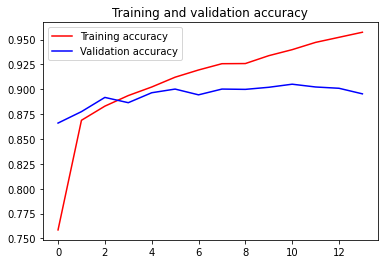

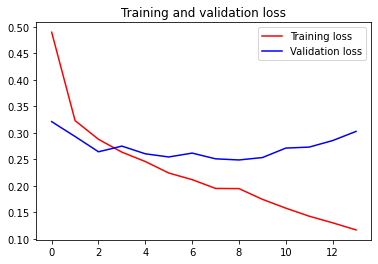

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [ ]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.9573749899864197
Validation Accuracy: 0.9050999879837036
